In [1]:
import time
import sys
import os
from PIL import Image
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import warnings
warnings.simplefilter("ignore")

In [2]:
train_img= r"C:\Users\Asus\Desktop\PG Project\Nandhini\colon_image_set\colon_image_sets\Training"
labels = os.listdir(train_img)
print("No. of labels in the Training set: {}".format(len(labels)))
print("-----------------")
os.chdir(train_img)
for label in labels:
    print("{}, {} files".format(label, len(os.listdir(train_img+ '//' +label))))

No. of labels in the Training set: 2
-----------------
colon_aca, 3493 files
colon_n, 3487 files


In [4]:
test_img = r"C:\Users\Asus\Desktop\PG Project\Nandhini\colon_image_set\colon_image_sets\Testing"
labels = os.listdir(train_img)
print("No. of labels in the Testing set: {}".format(len(labels)))
print("-----------------")
os.chdir(test_img)
for label in labels:
    print("{}, {} files".format(label, len(os.listdir(test_img+ '//' +label))))

No. of labels in the Testing set: 2
-----------------
colon_aca, 1003 files
colon_n, 1003 files


Next, we will plot 10 images aca tumor training images

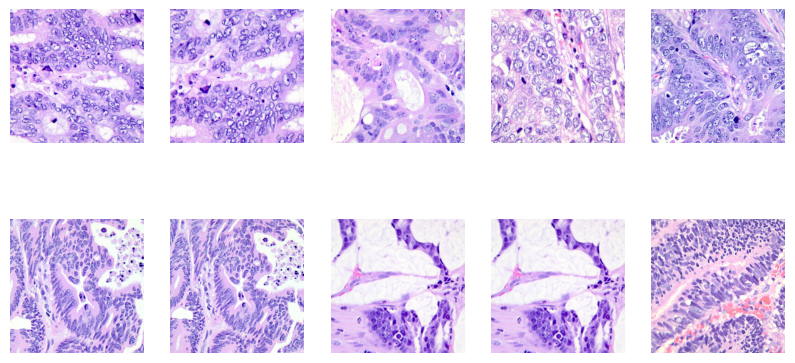

In [5]:
colon_aca = r"C:\Users\Asus\Desktop\PG Project\Nandhini\colon_image_set\colon_image_sets\Training\colon_aca"
sub_class = os.listdir(colon_aca)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:10])):
    plt.subplot(2,5,e+1)
    img = plt.imread(os.path.join(colon_aca,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis('off')

Since this dataset already contains augmented images, so further data augmentation will not be required.  
We will use the ImageDataGenerator class from Keras to split the data into training and validation sets.

In [6]:
img_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)
                                


train_generator = img_datagen.flow_from_directory(train_img,
                                                  class_mode='binary',
                                                 shuffle=True,
                                                 batch_size=32,
                                                 subset='training',
                                                 target_size=(100,100))
                                                 
valid_generator = img_datagen.flow_from_directory(test_img,
                                                 shuffle=True,
                                                  class_mode='binary',
                                                  batch_size=16,
                                                  subset='validation',
                                                 target_size=(100,100))

# Create a lablel_map dictionary that we will use for predicting on unseen data
label_map = (train_generator.class_indices)
print('Label mappings:\n')
label_map

Found 5585 images belonging to 2 classes.
Found 400 images belonging to 3 classes.
Label mappings:



{'colon_aca': 0, 'colon_n': 1}

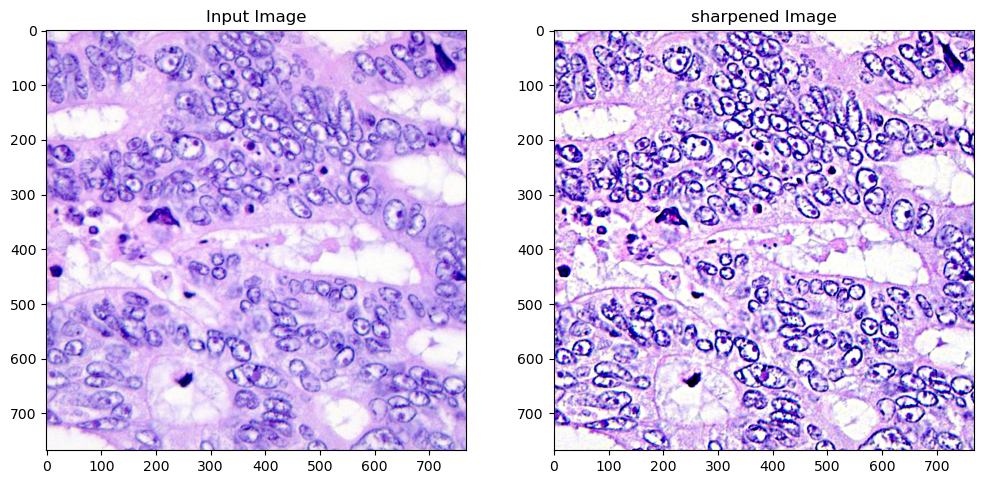

In [7]:
from skimage import io
from skimage.filters import unsharp_mask

img = io.imread(r"C:\Users\Asus\Desktop\PG Project\Nandhini\colon_image_set\colon_image_sets\Training\colon_aca\colonca1508.jpeg")

#sharpened = unsharp_mask(image0, radius=1.0, amount=1.0)
sharped_img = unsharp_mask(img, radius=5, amount=2)


import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(sharped_img, cmap='gray')
ax2.title.set_text('sharpened Image')

plt.show()

(768, 768)


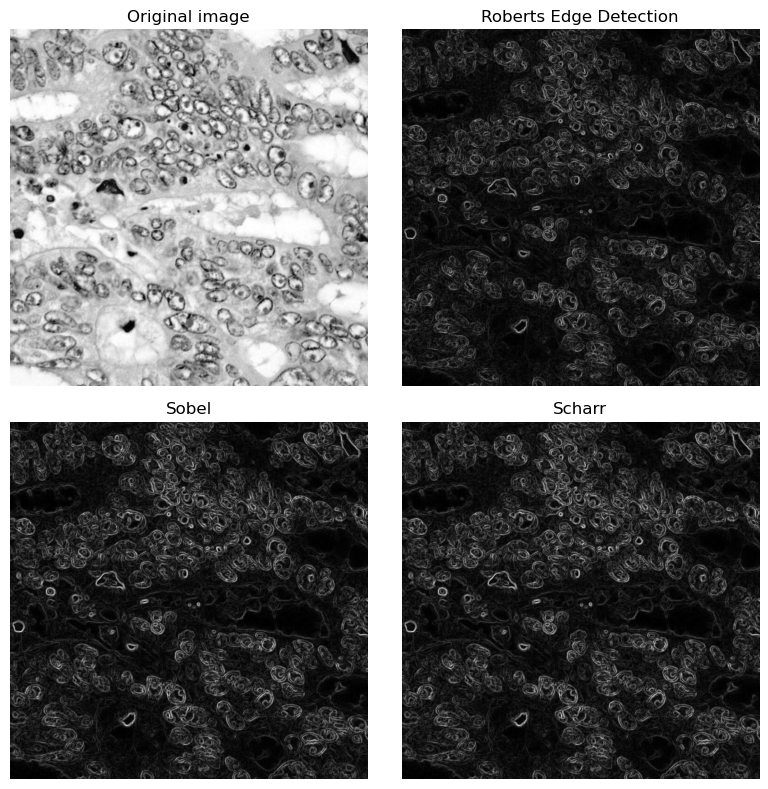

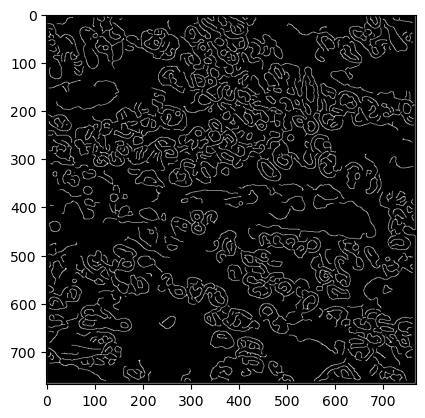

In [8]:
# Edge Detection


import matplotlib.pyplot as plt
from skimage import io
from skimage.filters import roberts, sobel, scharr, prewitt

img = io.imread(r"C:\Users\Asus\Desktop\PG Project\Nandhini\colon_image_set\colon_image_sets\Training\colon_aca\colonca1508.jpeg", as_gray=True)  #Convert to grey scale
print(img.shape)
#plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest')

edge_roberts = roberts(img)
#plt.imshow(edge_roberts, cmap=plt.cm.gray, interpolation='nearest')
edge_sobel = sobel(img)
edge_scharr = scharr(img)
edge_prewitt = prewitt(img)


fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                         figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(edge_roberts, cmap=plt.cm.gray)
ax[1].set_title('Roberts Edge Detection')

ax[2].imshow(edge_sobel, cmap=plt.cm.gray)
ax[2].set_title('Sobel')

ax[3].imshow(edge_scharr, cmap=plt.cm.gray)
ax[3].set_title('Scharr')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

#Another edge filter is Canny. This is not just a single operation
#It does noise reduction, gradient calculation, and edge tracking among other things. 
#Canny creates a binary file, true or false pixels. 
from skimage import feature
edge_canny = feature.canny(img, sigma=3)
plt.imshow(edge_canny,cmap='gray')

##  CNN model 
 

In [9]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(100,100,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.4))


model.add(Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

In [10]:
callbacks_list = [EarlyStopping( monitor='accuracy', patience=5, ),
                  ModelCheckpoint( filepath='/content/drive/MyDrive/train results/models/keras_colon_cancer_classification.h5',
                                  monitor='val_accuracy', save_best_only=True, ) ]


Next, we compile the model using the adam optimizer and the categoical_crossentropy loss function since this is a multi-class classification problem.

In [11]:
model.compile(optimizer=RMSprop(),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [12]:
history = model.fit(train_generator, validation_data=valid_generator,
                   steps_per_epoch=train_generator.n//train_generator.batch_size,
                   validation_steps=valid_generator.n//valid_generator.batch_size,
                    callbacks=[callbacks_list],
                    epochs=3)

Epoch 1/3
174/174 [==============================] - 140s 789ms/step - loss: 0.6927 - accuracy: 0.5057 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/3
174/174 [==============================] - 128s 732ms/step - loss: 0.6603 - accuracy: 0.6008 - val_loss: 0.6637 - val_accuracy: 0.5725
Epoch 3/3
174/174 [==============================] - 127s 729ms/step - loss: 0.4996 - accuracy: 0.7715 - val_loss: 0.2859 - val_accuracy: 0.8975


### Plotting model training and validation curves.


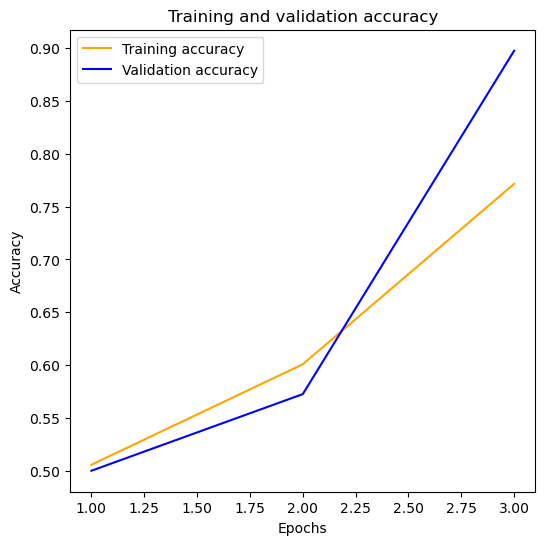

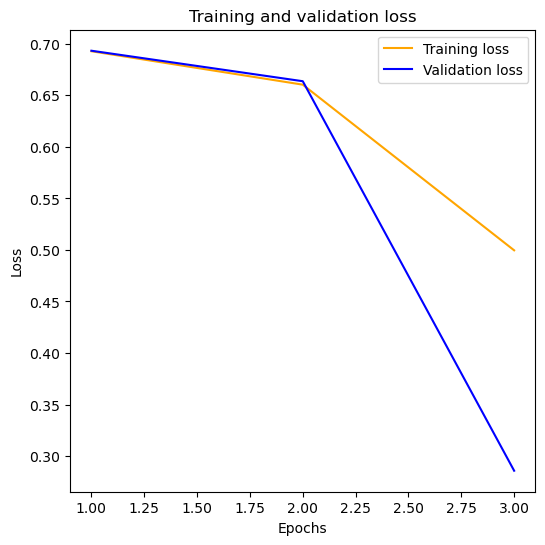

In [13]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_accuracy) + 1)
plt.figure(figsize=(6,6))
plt.plot(epochs, training_accuracy, 'orange', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(6,6))

plt.plot(epochs, training_loss, 'orange', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [14]:
import fastai
import fastbook

In [15]:
from fastai.vision.all import *
path = train_img

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

dls = dblock.dataloaders(path,bs=64)
#dls.normalize(imagenet_stats)

AttributeError: 'AxesImage' object has no property 'rows'

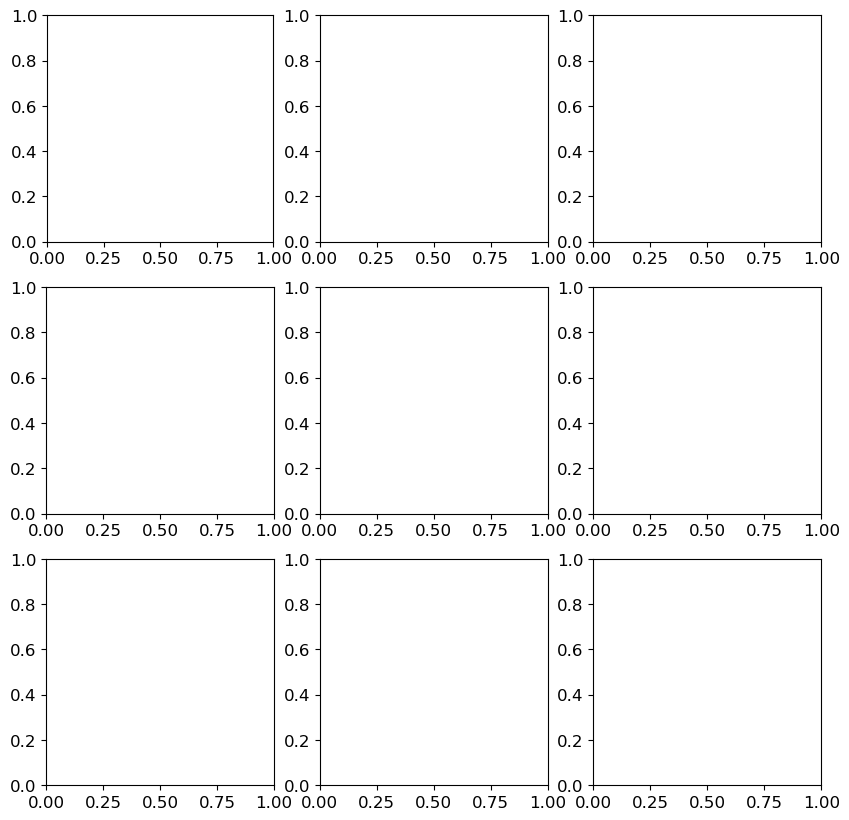

In [16]:
dls.show_batch(rows=4, figsize=(10,10))

In [17]:
learn = cnn_learner(dls, models.resnet50, metrics=accuracy)

In [18]:
learn.fit_one_cycle(1)

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
#learn.fit_one_cycle(1, 1e-05)

In [ ]:
#learn.save(r"C:\Users\Asus\Desktop\resnet50")

In [19]:
interp_vgg = ClassificationInterpretation.from_learner(learn)

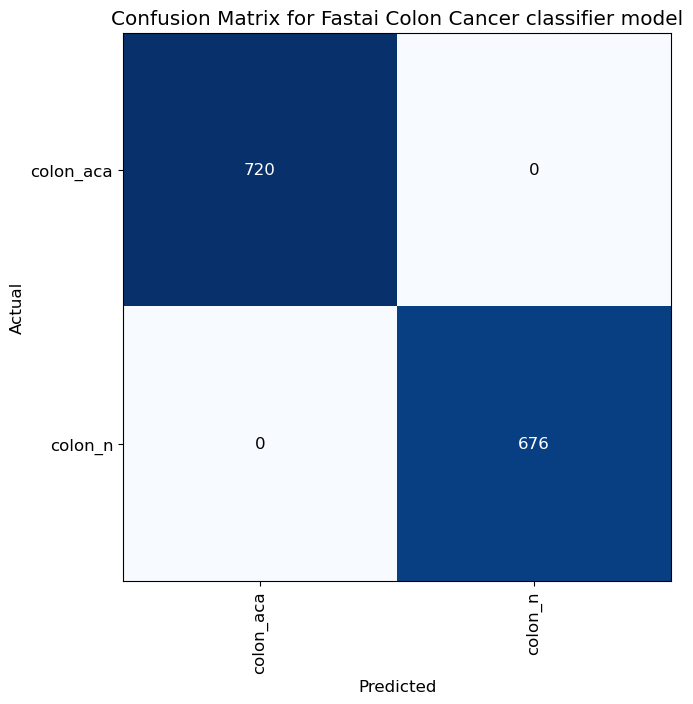

In [20]:
interp_vgg.plot_confusion_matrix(figsize=(7,7),
                                 title='Confusion Matrix for Fastai Colon Cancer classifier model')

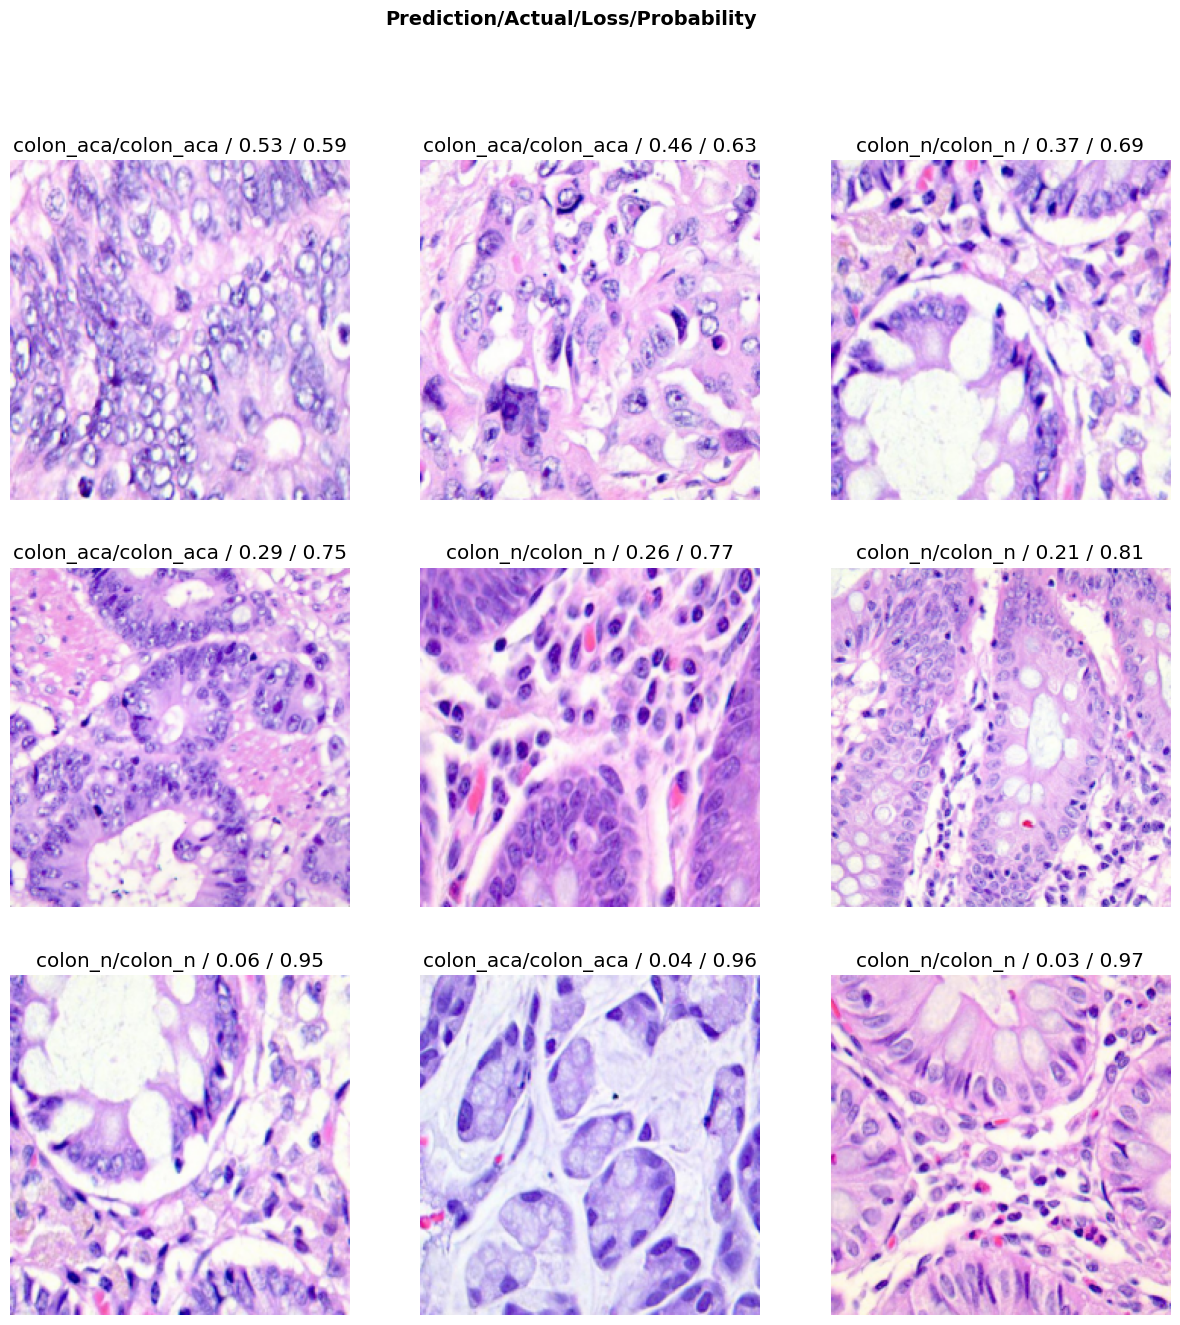

In [21]:
interp_vgg.plot_top_losses(9, figsize=(15,15))